
# 01 — Logistic Regression for Classificatio

**KR**: 고객 이탈(Churn) 예측 문제를 예시로, *전처리 → 학습/튜닝 → 평가 → 임계값 최적화 → 아티팩트 저장*을 Jupyter에서 재현합니다.  
**EN**: Using customer churn as an example, this notebook reproduces *preprocessing → training/tuning → evaluation → threshold optimization → artifact saving*.

- Dataset: `data/sample_churn.csv` (synthetic)
- Artifacts output dir: `artifacts/`


## 1) Environment & Imports

In [3]:

# Optional: install dependencies if needed
# !pip install numpy pandas scikit-learn matplotlib joblib

import os, json
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve, confusion_matrix,
    classification_report
)

from joblib import dump

import matplotlib
import matplotlib.pyplot as plt

# Ensure non-interactive backend if running headless
matplotlib.rcParams["figure.dpi"] = 120

BASE_DIR = Path.cwd()
DATA_CSV = BASE_DIR / "data" / "sample_churn.csv"
ARTIFACTS_DIR = BASE_DIR / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

DATA_CSV


WindowsPath('C:/Users/Owner/사이킥_런/data/sample_churn.csv')

## 2) Load Dataset

In [4]:

df = pd.read_csv(DATA_CSV)
print(df.shape)
df.head()


(2000, 11)


,tenure,monthly_charges,total_charges,support_calls,data_usage_gb,contract_type,payment_method,internet_service,paperless_billing,is_senior,churned
0,6,26.21,315.72,5,19.43,month-to-month,credit_card,dsl,1,0,1
1,55,65.83,3507.37,8,14.76,one-year,credit_card,dsl,0,0,1
2,47,32.90,1135.37,6,21.06,one-year,bank_transfer,none,0,0,0
3,31,35.23,827.09,3,18.51,two-year,electronic_check,fiber,0,0,0
4,31,83.23,2793.37,0,13.15,one-year,mailed_check,fiber,0,0,0


## 3) Quick EDA (KR/EN)

Target value counts:
churned
0    1084
1     916
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
tenure,2000.0,35.49700,20.884565,0.00,17.0000,36.000,54.0000,71.00
monthly_charges,2000.0,70.06846,28.948972,20.05,44.6300,69.635,95.4600,119.98
total_charges,2000.0,2477.18313,1863.134647,0.00,969.3150,2041.315,3744.0575,8177.35
support_calls,2000.0,5.02900,3.156920,0.00,2.0000,5.000,8.0000,10.00
data_usage_gb,2000.0,20.01157,14.034272,0.14,9.9575,16.630,26.9425,102.96
paperless_billing,2000.0,0.56200,0.496265,0.00,0.0000,1.000,1.0000,1.00
is_senior,2000.0,0.14400,0.351178,0.00,0.0000,0.000,0.0000,1.00
churned,2000.0,0.45800,0.498357,0.00,0.0000,0.000,1.0000,1.00


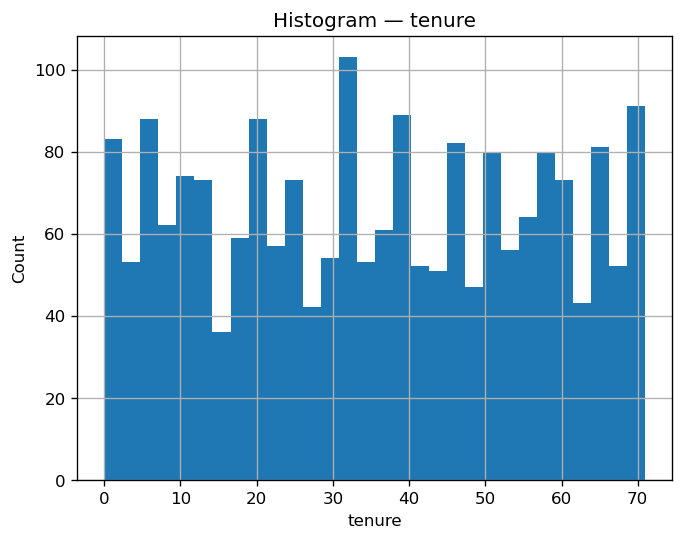

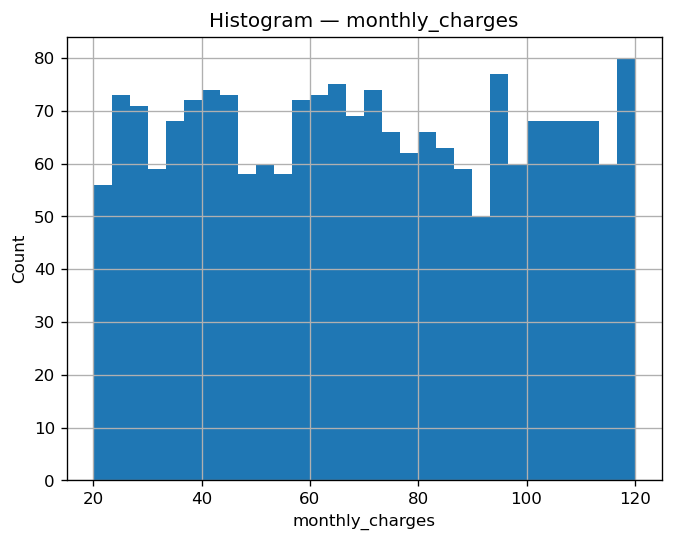

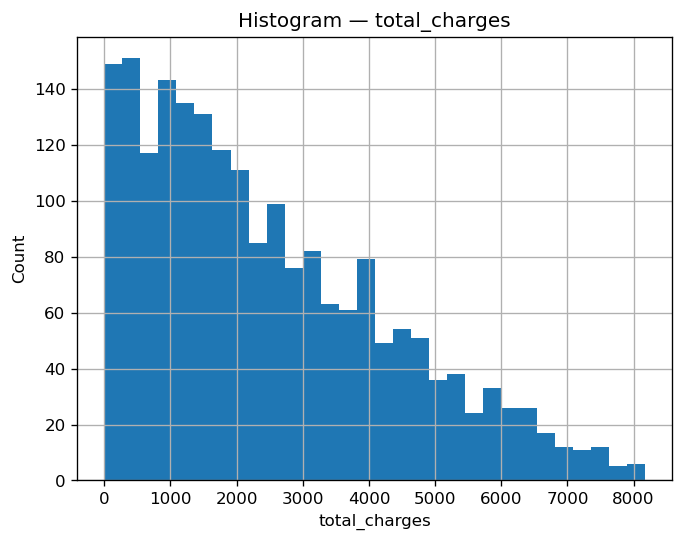

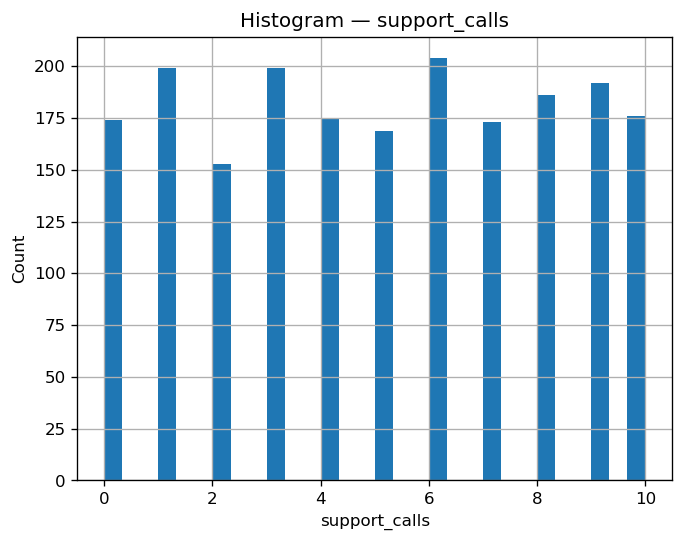

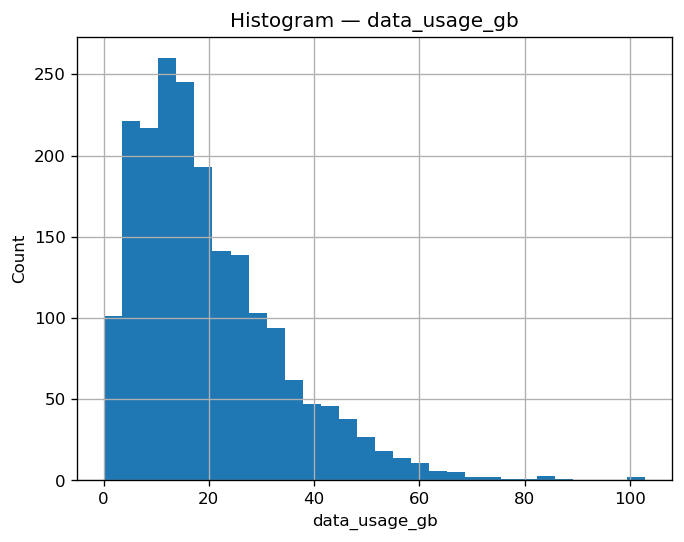

In [5]:

# Target distribution
print("Target value counts:")
print(df['churned'].value_counts(dropna=False).sort_index())

# Basic numeric summary
display(df.describe(include=[np.number]).T)

# Plot a few numeric histograms (one per figure)
num_cols = ['tenure','monthly_charges','total_charges','support_calls','data_usage_gb']
for c in num_cols:
    plt.figure()
    df[c].hist(bins=30)
    plt.title(f"Histogram — {c}")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()


## 4) Train/Test Split

In [6]:

X = df.drop(columns=['churned'])
y = df['churned'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((1600, 10), (400, 10))

## 5) Preprocessing & Pipeline (ColumnTransformer + LogisticRegression)

In [7]:

numeric_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','bool','category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)

logreg = LogisticRegression(
    solver='liblinear',  # supports L1/L2
    max_iter=1000,
    class_weight='balanced'
)

pipe = Pipeline(steps=[('preprocess', preprocess), ('log', logreg)])

# Keep grid modest in notebook to avoid long runs. Expand if needed.
param_grid = {
    'log__C': [0.1, 1.0, 10.0],
    'log__penalty': ['l1', 'l2'],
}

param_grid


{'log__C': [0.1, 1.0, 10.0], 'log__penalty': ['l1', 'l2']}

## 6) Train with GridSearchCV

In [9]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1, refit=True)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best_pipe = gs.best_estimator_


Best params: {'log__C': 0.1, 'log__penalty': 'l1'}


## 7) Evaluation (Default Threshold 0.5)

In [10]:

proba_test = best_pipe.predict_proba(X_test)[:, 1]
y_pred_default = (proba_test >= 0.5).astype(int)

metrics_default = {
    "accuracy": float(accuracy_score(y_test, y_pred_default)),
    "precision": float(precision_score(y_test, y_pred_default, zero_division=0)),
    "recall": float(recall_score(y_test, y_pred_default, zero_division=0)),
    "f1": float(f1_score(y_test, y_pred_default, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_test, proba_test)),
    "pr_auc": float(average_precision_score(y_test, proba_test)),
}
metrics_default


{'accuracy': 0.6925,
 'precision': 0.6363636363636364,
 'recall': 0.7650273224043715,
 'f1': 0.6947890818858561,
 'roc_auc': 0.7609730301427816,
 'pr_auc': 0.7160121046965999}

## 8) Curves & Confusion Matrix (Default Threshold)

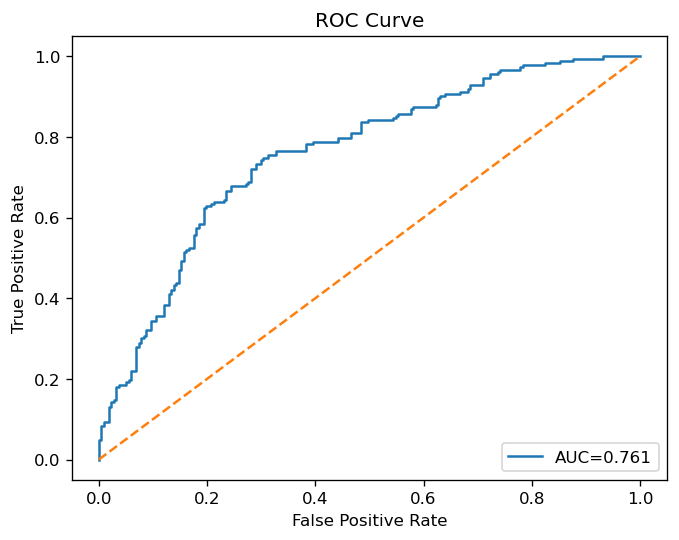

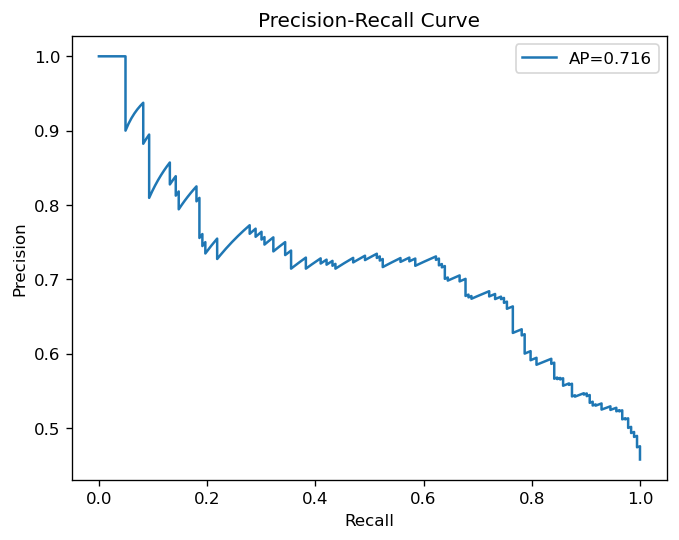

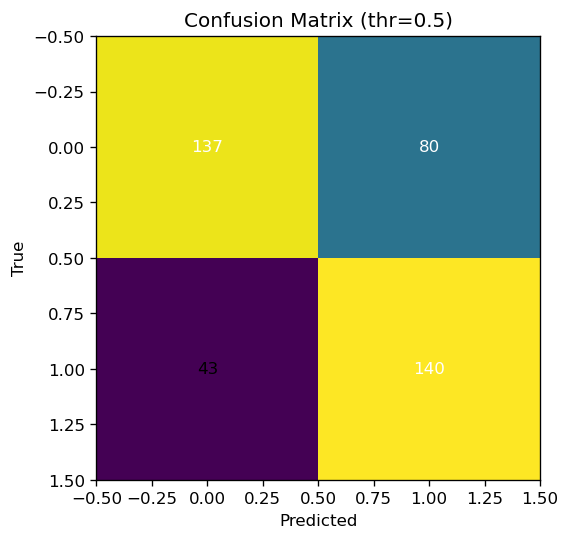

array([[137,  80],
       [ 43, 140]], dtype=int64)

In [11]:

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
auc = roc_auc_score(y_test, proba_test)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()

# Confusion Matrix (default)
cm_def = confusion_matrix(y_test, y_pred_default)
plt.figure()
plt.imshow(cm_def, interpolation='nearest')
plt.title("Confusion Matrix (thr=0.5)")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm_def):
    plt.text(j, i, str(v), ha='center', va='center',
             color='white' if v > cm_def.max()/2 else 'black')
plt.show()
cm_def


## 9) Threshold Optimization (F1 / Youden's J)

In [12]:

def optimize_threshold_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1s = 2 * (prec * rec) / np.maximum(prec + rec, 1e-9)
    thr_candidates = np.append(thr, 1.0)
    best_idx = int(np.nanargmax(f1s))
    return float(thr_candidates[best_idx]), float(f1s[best_idx])

def optimize_threshold_youden(y_true, proba):
    fpr, tpr, thr = roc_curve(y_true, proba)
    J = tpr - fpr
    best_idx = int(np.nanargmax(J))
    return float(thr[best_idx]), float(J[best_idx])

thr_f1, best_f1 = optimize_threshold_f1(y_test, proba_test)
thr_youden, best_J = optimize_threshold_youden(y_test, proba_test)

thr_f1, best_f1, thr_youden, best_J


(0.5211499274485124,
 0.7106598984771574,
 0.5312185523768898,
 0.4444864143436328)

In [13]:

# Apply F1-optimal threshold
y_pred_opt = (proba_test >= thr_f1).astype(int)
metrics_opt = {
    "accuracy": float(accuracy_score(y_test, y_pred_opt)),
    "precision": float(precision_score(y_test, y_pred_opt, zero_division=0)),
    "recall": float(recall_score(y_test, y_pred_opt, zero_division=0)),
    "f1": float(f1_score(y_test, y_pred_opt, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_test, proba_test)),
    "pr_auc": float(average_precision_score(y_test, proba_test)),
    "threshold": thr_f1,
    "criterion": "f1"
}
metrics_opt


{'accuracy': 0.715,
 'precision': 0.6635071090047393,
 'recall': 0.7650273224043715,
 'f1': 0.7106598984771574,
 'roc_auc': 0.7609730301427816,
 'pr_auc': 0.7160121046965999,
 'threshold': 0.5211499274485124,
 'criterion': 'f1'}

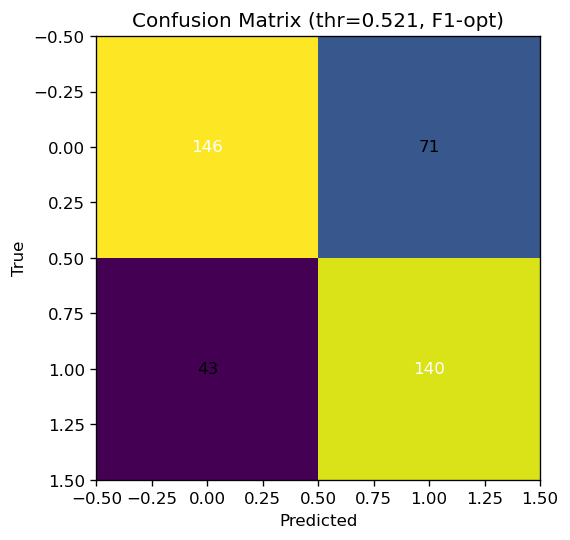

array([[146,  71],
       [ 43, 140]], dtype=int64)

In [14]:

# Confusion Matrix (optimized)
cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure()
plt.imshow(cm_opt, interpolation='nearest')
plt.title(f"Confusion Matrix (thr={thr_f1:.3f}, F1-opt)")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), v in np.ndenumerate(cm_opt):
    plt.text(j, i, str(v), ha='center', va='center',
             color='white' if v > cm_opt.max()/2 else 'black')
plt.show()
cm_opt


## 10) Feature Importance (Coefficients)

In [15]:

pre = best_pipe.named_steps['preprocess']
try:
    feature_names = pre.get_feature_names_out()
except Exception:
    feature_names = [f"f{i}" for i in range(best_pipe.named_steps['log'].coef_.shape[1])]

coef = best_pipe.named_steps['log'].coef_[0]
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "abs_coef": np.abs(coef)
}).sort_values("abs_coef", ascending=False)

coef_df.head(20)


,feature,coef,abs_coef
0,num__tenure,-0.590379,0.590379
1,num__monthly_charges,0.474843,0.474843
3,num__support_calls,0.390759,0.390759
9,cat__contract_type_two-year,-0.378268,0.378268
7,cat__contract_type_month-to-month,0.219064,0.219064
12,cat__payment_method_electronic_check,0.179275,0.179275
8,cat__contract_type_one-year,-0.119402,0.119402
14,cat__internet_service_dsl,-0.098521,0.098521
11,cat__payment_method_credit_card,-0.017768,0.017768
4,num__data_usage_gb,0.016112,0.016112


## 11) Save Artifacts (Model/Reports/Plots)

In [16]:

# Save metrics to JSON
result_dict = {
    "best_params": gs.best_params_,
    "metrics_default_threshold": metrics_default,
    "metrics_at_opt_threshold": metrics_opt
}
with open(ARTIFACTS_DIR / "metrics.json", "w", encoding="utf-8") as f:
    json.dump(result_dict, f, indent=2, ensure_ascii=False)

# Save classification report (at optimized threshold)
report = classification_report(y_test, (proba_test >= metrics_opt["threshold"]).astype(int), zero_division=0)
with open(ARTIFACTS_DIR / "classification_report.txt", "w", encoding="utf-8") as f:
    f.write(report)

# Save coefficients
coef_df.to_csv(ARTIFACTS_DIR / "coef_importance.csv", index=False, encoding="utf-8")

# Save model
dump(best_pipe, ARTIFACTS_DIR / "model.joblib")

# Save figures
# Replot and save to files
plt.figure()
fpr, tpr, _ = roc_curve(y_test, proba_test)
auc = roc_auc_score(y_test, proba_test)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "roc_curve.png")
plt.close()

plt.figure()
prec, rec, _ = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "pr_curve.png")
plt.close()

# Confusion matrices
def plot_and_save_cm(cm, out_path, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center',
                 color='white' if v > cm.max()/2 else 'black')
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()

plot_and_save_cm(confusion_matrix(y_test, y_pred_default), ARTIFACTS_DIR / "confusion_matrix_default.png", "Confusion Matrix (thr=0.5)")
plot_and_save_cm(confusion_matrix(y_test, (proba_test >= metrics_opt["threshold"]).astype(int)), ARTIFACTS_DIR / "confusion_matrix_optimized.png", f"Confusion Matrix (thr={metrics_opt['threshold']:.3f})")

print("Artifacts saved to:", ARTIFACTS_DIR.resolve())


Artifacts saved to: C:\Users\Owner\사이킥_런\artifacts


## 12) (Optional) Use Your Own CSV

In [17]:

# Set your own CSV path and rerun from Section 2
# DATA_CSV = Path('/path/to/your.csv')
# df = pd.read_csv(DATA_CSV)
# ... continue the same steps


## 13) (Optional) 2D Decision Boundary Demo

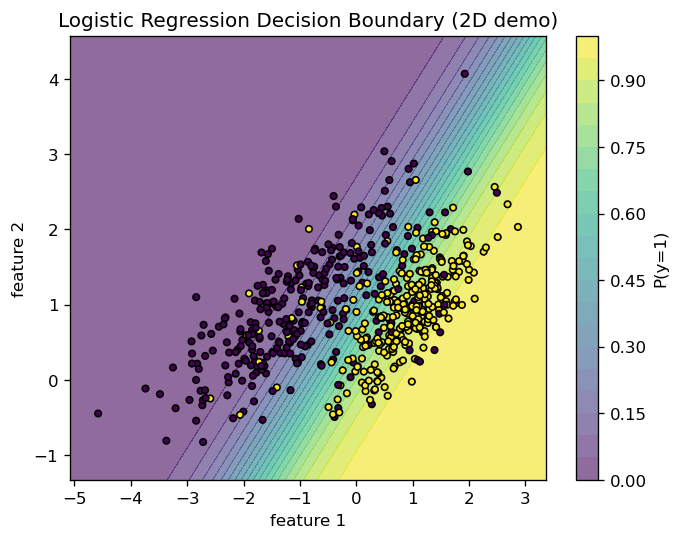

In [18]:

from sklearn.datasets import make_classification

X2, y2 = make_classification(n_samples=600, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, class_sep=1.0, flip_y=0.2, random_state=42)

pipe2 = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression(C=1.0, solver='lbfgs'))])
pipe2.fit(X2, y2)

# Plot decision surface
x_min, x_max = X2[:,0].min() - .5, X2[:,0].max() + .5
y_min, y_max = X2[:,1].min() - .5, X2[:,1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = pipe2.predict_proba(grid)[:,1].reshape(xx.shape)

plt.figure()
cs = plt.contourf(xx, yy, Z, levels=20, alpha=0.6)
plt.colorbar(cs, label="P(y=1)")
plt.scatter(X2[:,0], X2[:,1], c=y2, s=15, edgecolors='k')
plt.title("Logistic Regression Decision Boundary (2D demo)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()
